## Exploaratory Data Analysis of Youtube Channel No Rolls Barred

## 1. Aims, objectives and background

Playing board games is one of my favourite hobbies when spending time with friends and family. I love the problem solving, creative thinking, teamwork, competitive nature when playing any board games. Especially whenever you get to try out a new game for the first time, the anticipation and understanding of how the game is designed is intriguing. I wanted to search for a youtube channel that was centered around board games in the hopes of seeing some friendly competitive games as well as obviously discovering any new board games that might interest me.

One channel I came across which I was interested in was No Rolls Barred, which has a subscriber base of 320K followers. 

### 1.2. Aims and objectives


Within this project, I would like to explore the following:

* Getting to know Youtube API and how to obtain video data.
* Analyzing video data and verify different common "myths" about what makes a video do well on Youtube, for example:
    * Does the number of likes and comments matter for a video to get more views?
    * Does the video duration matter for views and interaction (likes/ comments)?
    * Does title length matter for views?
    * How many tags do good performing videos have? What are the common tags among these videos?
    * How often do they upload new videos? On which days in the week?
* Explore NLP techniques using sentiment analysis
    * Which popular topics are being covered in the videos (e.g. using wordcloud for video titles)?
    * Which questions are being asked in the comment sections in the videos

### 1.3. Steps of the project


1. Obtain video meta data via Youtube API for the top 10-15 channels in the data science niche (this includes several small steps: create a developer key, request data and transform the responses into a usable data format)
2. Prepocess data and engineer additional features for analysis
3. Exploratory data analysis
4. Conclusions

## 2. Data Collection & Preprocessing

Firstly, before I could retrieve the data from youtube, I needed to activate in Google Developers Console my unique API key to give me authorization. Once activating the Youtube API for my application, I could now establish a connection with Youtube API services. Then, I navigated to Youtube to retrieve the unique channel IDs for the channels I intended to analyse, utilising their respective URLs. Finally, I developed functions to gather channel statistics through the API.

In [34]:
#Libraries

from googleapiclient.discovery import build
import pandas as pd
import json
from IPython.display import JSON 
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
# NLP libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from wordcloud import WordCloud


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gavivignes/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/gavivignes/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [92]:
with open('secrets.json', 'r') as f:
    api_config = json.load(f)

In [36]:
channel_ids = ['UC5UQPZe-8v4_UP1uxi4Mv6A',
               'UCiwBbXQlljGjKtKhcdMliRA',
               'UCO-hn9MJOu7pOUdGSabKGvA',
               'UCBRTbbK-avyRJSSJ2GyHs_w'
               #more channel ids
               ]

In [93]:
api_service_name = "youtube"
api_version = "v3"

# Get credentials and create an API client

youtube = build(
    api_service_name, api_version, developerKey=api_config.get('api_key'))

### Get channel statistics
Retrieve channel statistics for the 4 channels using the `get_channel_stats` function defined below 

In [38]:
def get_stats(youtube, channel_ids):
    """
    Retrieve channel statistics: channel name, description, total views, subscriber count, upload count,  playlist id
    Params:
        youtube: the build object from googleapiclient.discovery
        channels_ids: list of channel IDs
    Returns:
        DataFrame containing the channel statistics for all channels in the provided list: channel name, description, total views, subscriber count, upload count,  playlist id
    """
    data = []
    
    request = youtube.channels().list(
    part="snippet,contentDetails,statistics",
    id=','.join(channel_ids)
    )
    response = request.execute()
    
    #loop through channel items
    for item in response['items']:
        channel_dict = {'channel_name': item['snippet']['title'],
                        'description': item['snippet']['description'],
                        'total_views': item['statistics']['viewCount'],
                        'total_uploads': item['statistics']['videoCount'],
                        'total_subscribers': item['statistics']['subscriberCount'],
                        'channel_unique_playlist_id': item['contentDetails']['relatedPlaylists']['uploads']}
        
        data.append(channel_dict)
    
    df = pd.DataFrame(data)
    return df
                        


In [39]:
stats = get_stats(youtube, channel_ids)
stats

channel_name                                        description  \
0  Good Time Society  Welcome to Good Time Society! Stick around awh...   
1     The Dice Tower  Video reviews of games, top 10 lists, live pla...   
2    No Rolls Barred  Welcome to the Official No Rolls Barred YouTub...   
3           Actualol         Board game reviews with a sense of humour.   

  total_views total_uploads total_subscribers channel_unique_playlist_id  
0     4559173           553             58100   UUBRTbbK-avyRJSSJ2GyHs_w  
1   332478165         23180            334000   UUiwBbXQlljGjKtKhcdMliRA  
2    57216291           365            320000   UU5UQPZe-8v4_UP1uxi4Mv6A  
3     8584495           189            106000   UUO-hn9MJOu7pOUdGSabKGvA

In [40]:
## change data type of count columns from object to integer

int_colums = ['total_views', 'total_uploads','total_subscribers']
stats[int_colums] = stats[int_colums].astype(int)
stats.dtypes

channel_name                  object
description                   object
total_views                    int64
total_uploads                  int64
total_subscribers              int64
channel_unique_playlist_id    object
dtype: object

### Get Videos ids
Retrieve video ids for each channel using `get_video_ids` function below

In [41]:
def get_video_ids(youtube, playlist_id):
    """
    Retieve video IDs of all videos in the given playlist
    Params:
    
    youtube: the build object from googleapiclient.discovery
    playlist_id: playlist ID of the channel
    
    Returns:
    Video IDs of all videos in the playlist
    
    """
    video_ids = []

    request = youtube.playlistItems().list(
        part="snippet, contentDetails",
        playlistId=playlist_id,
        maxResults=50
    )
    response = request.execute()

    for item in response['items']:
        video_ids.append(item['contentDetails']['videoId'])

    next_page_token = response.get('nextPageToken')
    while next_page_token is not None:
        request = youtube.playlistItems().list(
            part="contentDetails",
            playlistId=playlist_id,
            maxResults=50,
            pageToken=next_page_token  # Add pageToken to request the next page
        )
        response = request.execute()

        for item in response['items']:
            video_ids.append(item['contentDetails']['videoId'])

        next_page_token = response.get('nextPageToken')
        

    return video_ids

In [42]:
playlist_id_1 = "UU5UQPZe-8v4_UP1uxi4Mv6A"
playlist_id_2 = "UUO-hn9MJOu7pOUdGSabKGvA"
playlist_id_3 = "UUiwBbXQlljGjKtKhcdMliRA"
playlist_id_4 = "UUBRTbbK-avyRJSSJ2GyHs_w"


videos1 = get_video_ids(youtube, playlist_id_1)
videos2 = get_video_ids(youtube, playlist_id_2)
videos3 = get_video_ids(youtube, playlist_id_3)
videos4 = get_video_ids(youtube, playlist_id_4)

In [43]:
print(len(videos1))
print(len(videos2))
print(len(videos3))
print(len(videos4))


364
190
19942
553


In [64]:
all_videos = videos1 + videos2 + videos3 + videos4
print(len(all_videos))

21049


### Retrieve video data for each video id

In [65]:
def retrieve_video_info(youtube,videos):
    """
    Retieve video data of for each video id in the given playlist
    Params:
    
    youtube: the build object from googleapiclient.discovery
    playlist_id: playlist ID of the channel
    
    Returns:
    Dataframe with statistics of videos, i.e.:
        video_id
        channelTitle
        channelId
        publishedAt
        title
        description
        duration
        caption
        viewCount
        likeCount
        favoriteCount
        commentCount
    """
    
    
    total_video_info = []

    for i in range(0, len(videos), 50):
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=','.join(videos[i:i+50])
        )
        response = request.execute()

        for video in response['items']:
            video_details = {'snippet': ['channelTitle','channelId','publishedAt','title','description'],
                             'contentDetails': ['duration', 'caption'],
                             'statistics': ['viewCount', 'likeCount', 'favoriteCount','commentCount']}
            video_info = {}
            video_info['video_id'] = video['id']

            for i in video_details.keys():
                for j in video_details[i]:
                    try:
                        video_info[j] = video[i][j]
                    except:
                        video_info[j] = None
            total_video_info.append(video_info)
    return pd.DataFrame(total_video_info)
    
                     

In [66]:
video_df = retrieve_video_info(youtube,all_videos)


In [241]:
video_df.head()

video_id     channelTitle                 channelId publishedAt  \
0  kM_si9hmUVU  No Rolls Barred  UC5UQPZe-8v4_UP1uxi4Mv6A  2024-01-30   
1  j8nHxk-446o  No Rolls Barred  UC5UQPZe-8v4_UP1uxi4Mv6A  2024-01-27   
2  VpYApxoFtfs  No Rolls Barred  UC5UQPZe-8v4_UP1uxi4Mv6A  2024-01-23   
3  55qSVewCieM  No Rolls Barred  UC5UQPZe-8v4_UP1uxi4Mv6A  2024-01-20   
4  uiPXTlOxeeU  No Rolls Barred  UC5UQPZe-8v4_UP1uxi4Mv6A  2024-01-19   

                                               title  \
0  Let's Play SPEEDPORT and CLICKPORT | Board Gam...   
1                            Monopoly, But ZOMBIES!!   
2               Let's Play DECORUM | Board Game Club   
3                POKER, But Backwards! | House Rules   
4  WATCH Chaotic Neutral Plays Dungeons & Dragons...   

                                         description  duration caption  \
0  #AD Clickport and Speedport are both available...    3325.0   false   
1  Join the DOMMUNIST PARTY! 👉 https://shorturl.a...    5189.0   false   
2  For uncut Board Game Club episodes, exclusive ...    3079.0   false   
3  Don't forget to JOIN THE DOMMUNIST PARTY! See ...    4436.0   false   
4  Watch all five episodes of Chaotic Neutral Pla...     135.0   false   

   viewCount  likeCount  favoriteCount  commentCount  likeRatio  commentRatio  
0      44389       2254              0           319  50.778346      7.186465  
1     254095      16371              0          1643  64.428659      6.466086  
2      82393       4184              0           282  50.781013      3.422621  
3     194183       8672              0           744  44.658904      3.831437  
4       8583        399              0            31  46.487242      3.611791

In [76]:
#check nulls
video_df.isnull().sum()

video_id         0
channelTitle     0
channelId        0
publishedAt      0
title            0
description      0
duration         0
caption          0
viewCount        0
likeCount        5
favoriteCount    0
commentCount     3
dtype: int64

In [77]:
video_df.dtypes

video_id         object
channelTitle     object
channelId        object
publishedAt      object
title            object
description      object
duration         object
caption          object
viewCount        object
likeCount        object
favoriteCount    object
commentCount     object
dtype: object

In [78]:
#only a few records so decided to drop the null values.
video_df.dropna(inplace=True)

In [79]:
video_df.isnull().sum()

video_id         0
channelTitle     0
channelId        0
publishedAt      0
title            0
description      0
duration         0
caption          0
viewCount        0
likeCount        0
favoriteCount    0
commentCount     0
dtype: int64

In [80]:
## change data type of count columns from object to integer
int_colums = ['viewCount', 'likeCount','favoriteCount','commentCount']
video_df[int_colums] = video_df[int_colums].astype(int)

In [81]:
video_df.dtypes

video_id         object
channelTitle     object
channelId        object
publishedAt      object
title            object
description      object
duration         object
caption          object
viewCount         int64
likeCount         int64
favoriteCount     int64
commentCount      int64
dtype: object

In [82]:
## change data type of publishedAt from object to datetime
video_df['publishedAt'] = pd.to_datetime(video_df['publishedAt']).dt.date
video_df['publishedAt'] = pd.to_datetime(video_df['publishedAt']).dt.tz_localize(None)



In [83]:
video_df.dtypes

video_id                 object
channelTitle             object
channelId                object
publishedAt      datetime64[ns]
title                    object
description              object
duration                 object
caption                  object
viewCount                 int64
likeCount                 int64
favoriteCount             int64
commentCount              int64
dtype: object

### Converting Youtube encoded timestamp

One of the things I had to do was to convert the duration column into seconds. When retreiveing the duration of a video from youtube, it always returns in an encoded timestamp format for example **PT18M18S**. This essentially is saying that the video is 18 minutes long and 18 seconds in total. But this is not what I want. So I created a function below that converts this format into seconds 







In [84]:
import re

def convert_youtube_ts_to_secs(timestamp):
    total = None

    # Define a regex pattern
    
    pattern = re.compile(r'PT(?:([0-9]+)H)?(?:([0-9]+)M)?(?:([0-9]+)S)?')

    # Use the pattern to extract hour, minute, and second
    match = pattern.match(timestamp)

    if match:
        hours = int(match.group(1) or 0)
        minutes = int(match.group(2) or 0)
        seconds = int(match.group(3) or 0)
        # print(f"Hours: {hours}, Minutes: {minutes}, Seconds: {seconds}")
        total = hours*3600 + minutes*60 + seconds
    else:
        total = None
        # print("No match found.")
    return total



In [85]:
#test
convert_youtube_ts_to_secs('PT18M18S')

1098

In [86]:
#apply function to duration column
video_df['duration'] = video_df['duration'].apply(convert_youtube_ts_to_secs)

In [137]:
video_df.groupby('channelTitle')['commentCount'].sum().reset_index()

channelTitle  commentCount
0           Actualol         30224
1  Good Time Society          8081
2    No Rolls Barred        151059
3     The Dice Tower        591673

### Get comments 
Using the `get_comments_in_videos` function defined below, I was able to retrieve as much comments as I could without exceeding the youtube API limit.

In [95]:
def get_comments_in_videos(youtube, videos):
    """
    Get top level comments as text from all videos with given IDs (only the first 10 comments due to quote limit of Youtube API)
    Params:
    
    youtube: the build object from googleapiclient.discovery
    video_ids: list of video IDs
    
    Returns:
    Dataframe with video IDs and associated top level comment in text.
    
    """
    all_comments = []
    
    for video_id in videos:
        try:   
            request = youtube.commentThreads().list(
                part="snippet,replies",
                videoId=video_id
            )
            response = request.execute()
        
            comments_in_video = [comment['snippet']['topLevelComment']['snippet']['textOriginal'] for comment in response['items'][0:10]]
            comments_in_video_info = {'video_id': video_id, 'comments': comments_in_video}

            all_comments.append(comments_in_video_info)
            
        except: 
            # When error occurs - most likely because comments are disabled on a video
            print('Could not get comments for video ' + video_id)
        
    return pd.DataFrame(all_comments)
        
    

In [ ]:
comments_df1 = get_comments_in_videos(youtube, videos1)
comments_df2 = get_comments_in_videos(youtube, videos2)
comments_df3 = get_comments_in_videos(youtube, videos3)
comments_df4 = get_comments_in_videos(youtube, videos4)


In [97]:
print(len(comments_df1))
print(len(comments_df2))
print(len(comments_df3))
print(len(comments_df4))


364
189
8187
551


In [98]:
comments_df= pd.concat([comments_df1, comments_df2, comments_df3, comments_df4], ignore_index=True)

I was able to retrieve comments for 9291 videos in total, with 1 video having list of 10 comments

In [131]:
comments_df

video_id                                           comments
0     kM_si9hmUVU  [Clickport and Speedport are both available to...
1     j8nHxk-446o  [Fill in the blank - Monopoly, But [BLANK].\nJ...
2     VpYApxoFtfs  [lol I want a pirates monopoly. thievery and t...
3     55qSVewCieM  [Don't forget to JOIN THE DOMMUNIST PARTY! See...
4     uiPXTlOxeeU  [LAURIE: Watch all five episodes of Chaotic Ne...
...           ...                                                ...
9286  0E2st7jTjN8  [Grecc, Becc and Nicc, I'm so happy for you to...
9287  pldrh9-auBw  [California pizza?  Give me the turkey. :), Ok...
9288  IWxLGcha82E                                                 []
9289  byE3L3jdvgQ  [Great stuff, Becca!  Keep on keeping on!, Bec...
9290  CjFSpjv3MfE  [This was a hilarious episode :)   Absolute bl...

[9291 rows x 2 columns]

In [139]:
#merge comments to original df and create a copy 
video_df_copy = video_df.merge(comments_df, how='left', on='video_id')


In [140]:
stats.dtypes

channel_name                  object
description                   object
total_views                    int64
total_uploads                  int64
total_subscribers              int64
channel_unique_playlist_id    object
dtype: object

# 3. Exploartory Data Analysis

Just to get things started off, I wanted to create a plot of the channels and their subscribers count. As we can see The Dice Tower is the most followed channel as 334K, followed by No Rolls Barred at 320K, then Actualol at 106K with Good Time Society the least followed out of the four channels at 58.1K.

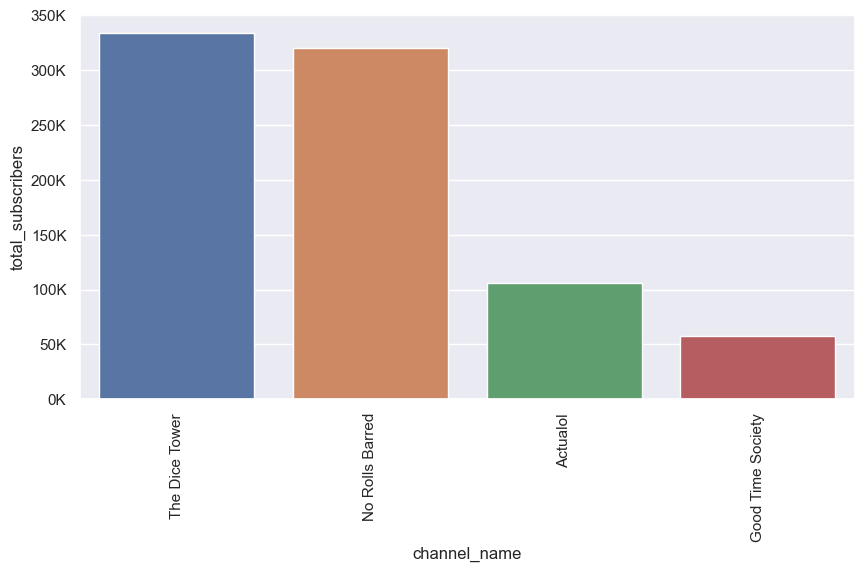

In [141]:
from matplotlib.ticker import FuncFormatter
# Create a function to format the y-axis labels in thousands
fig, axes = plt.subplots(figsize=(10,5))
ax = sns.barplot(x='channel_name', y='total_subscribers', data=stats.sort_values('total_subscribers', ascending=False))
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))
plot = ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
plt.show()

In [143]:
video_df.dtypes

video_id                 object
channelTitle             object
channelId                object
publishedAt      datetime64[ns]
title                    object
description              object
duration                float64
caption                  object
viewCount                 int64
likeCount                 int64
favoriteCount             int64
commentCount              int64
dtype: object

### Top 10 viewed/ liked videos

Next I wanted to visualise the top 10 viewed videos and top 10 liked videos. It was found that 6 out of the top 10 viewed videos were from the No Rolls Barred channel, with 3 belonging to The Dice Tower and 1 to Actualol. In regards to the top 10 liked videos, 8 videos belonged to No Rolls Barred Channel and 2 to Actualol. 

In [144]:
top10 = video_df_copy.sort_values('viewCount', ascending = False).iloc[0:10]
top10

video_id     channelTitle                 channelId publishedAt  \
54     jkN6xxyEgZc  No Rolls Barred  UC5UQPZe-8v4_UP1uxi4Mv6A  2023-06-17   
39     StdUwfhFtt4  No Rolls Barred  UC5UQPZe-8v4_UP1uxi4Mv6A  2023-09-02   
171    Hg5dAwpftRk  No Rolls Barred  UC5UQPZe-8v4_UP1uxi4Mv6A  2022-04-30   
16398  HKgz-UBEhss   The Dice Tower  UCiwBbXQlljGjKtKhcdMliRA  2016-10-13   
47     x_pbEZRDizQ  No Rolls Barred  UC5UQPZe-8v4_UP1uxi4Mv6A  2023-07-11   
20194  TuizqFFnQqY   The Dice Tower  UCiwBbXQlljGjKtKhcdMliRA  2014-06-26   
72     kbuGMYYatnI  No Rolls Barred  UC5UQPZe-8v4_UP1uxi4Mv6A  2023-04-08   
386    bpRtC_apXGU         Actualol  UCO-hn9MJOu7pOUdGSabKGvA  2022-02-04   
61     k2ixp5VozIs  No Rolls Barred  UC5UQPZe-8v4_UP1uxi4Mv6A  2023-05-13   
19430  p8Yas0a9Qf4   The Dice Tower  UCiwBbXQlljGjKtKhcdMliRA  2015-02-20   

                                                   title  \
54                 Monopoly, But COMMUNIST | House Rules   
39               Monopoly, But COMMUNIST 2 | House Rules   
171         Guess Who, But With VIBES Only | House Rules   
16398        Top 10 Essential Games Everyone Should Own!   
47                              We BOTH want to DIE!!!!!   
20194                     Top 10 Games for the Classroom   
72     Game Of Life, But WORST. LIFE. EVER | House Rules   
386                   10 Mistakes Most Board Gamers Make   
61       Snakes & Ladders, But ONLY SNAKES | House Rules   
19430                               Top 10 Games We HATE   

                                             description  duration caption  \
54     For uncut Board Game Club episodes, exclusive ...    3649.0   false   
39     For uncut Board Game Club episodes, exclusive ...    6052.0   false   
171    Check out our Kickstarter campaign to fund mor...    1907.0   false   
16398  Tom Vasel, Sam Healey, and Zee Garcia share th...    3302.0    true   
47     For uncut Board Game Club episodes, exclusive ...      58.0   false   
20194  Tom Vasel, Sam Healey, and Zee Garcia take a l...    2847.0   false   
72     For uncut Board Game Club episodes, exclusive ...    3874.0   false   
386    🟠 BECOME A PATRON: https://www.patreon.com/act...    1144.0   false   
61     For uncut Board Game Club episodes, exclusive ...    3573.0   false   
19430  Tom Vasel, Zee Garcia, and Sam Healey take a l...    4273.0   false   

       viewCount  likeCount  favoriteCount  commentCount  \
54       2017382      93583              0          8667   
39       1617635      67367              0          6064   
171      1337620      71847              0          2055   
16398    1311861      10735              0          1099   
47       1136169      65123              0           755   
20194    1035424       2832              0           188   
72        848859      28536              0          1047   
386       752547      28023              0          2825   
61        712311      27676              0          2124   
19430     707437       4300              0          1472   

                                                comments  
54     [ADAM: To see us read ALL the cards in the gam...  
39     [For uncut Board Game Club episodes, exclusive...  
171    [ADAM: For uncut Board Game Club episodes, exc...  
16398                                                NaN  
47     [Communist Monopoly was just the perfect depic...  
20194                                                NaN  
72     [I think the game was rigged, are these the sa...  
386    [If this is the first Actualol video you're se...  
61     [ADAM: For uncut Board Game Club episodes, exc...  
19430                                                NaN

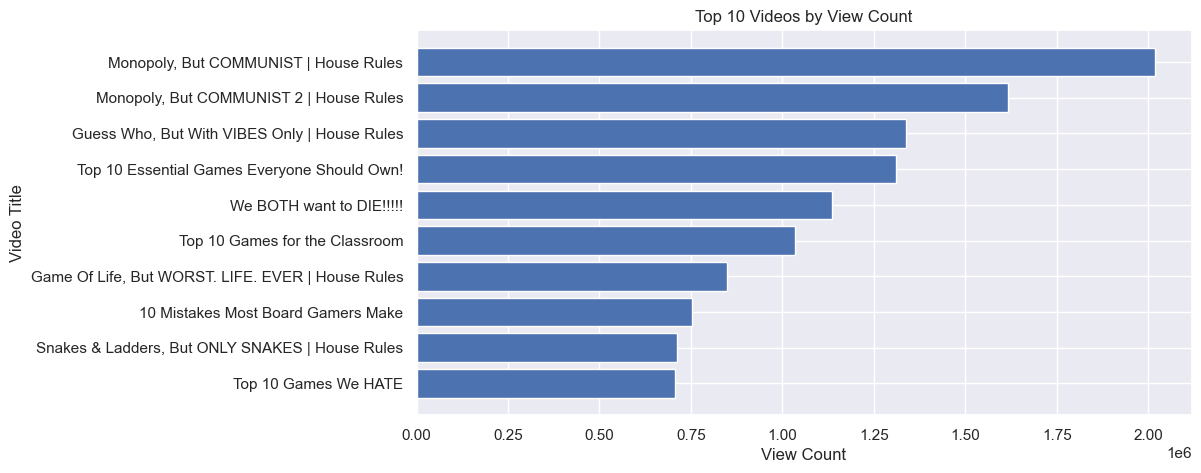

In [145]:
fig, ax = plt.subplots(figsize=(10,5))
ax.barh(top10.title, top10.viewCount)

# Adding labels and title
ax.set_xlabel('View Count')
ax.set_ylabel('Video Title')
ax.set_title('Top 10 Videos by View Count')

ax.invert_yaxis()

# Show the plot
plt.show()



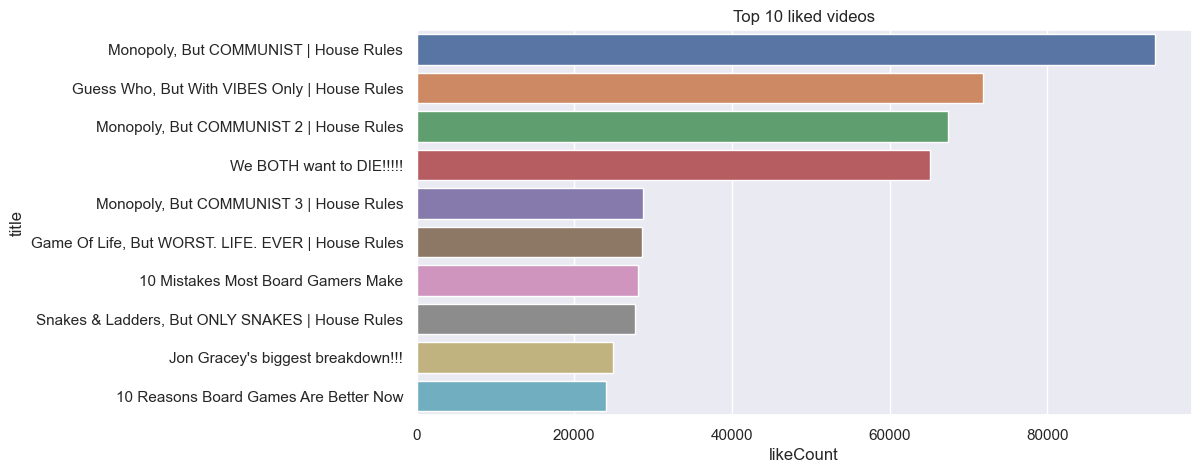

In [236]:
sns.set_theme()
fig, ax = plt.subplots(figsize=(10,5))
top10 = video_df_copy.sort_values('likeCount', ascending = False).head(10)
ax.set_xlabel('Liked Count')
ax.set_ylabel('Video Title')
ax.set_title('Top 10 liked videos')
ax = sns.barplot(x='likeCount',y='title', data=top10)

### Relationship between number of likes or comments vs number of views views?

From the above observation, the next thing I wanted to explore was whether number of likes or comments correlate with how many views a video reaches. From the scatterplots below, it can be seen that the number of views is strongly correlated with the number of comments/ likes of the video. The more number of likes or comments in a video, likely the more views. This is expected as with a larger audience size, there is the tendency for more engagement in a video. 

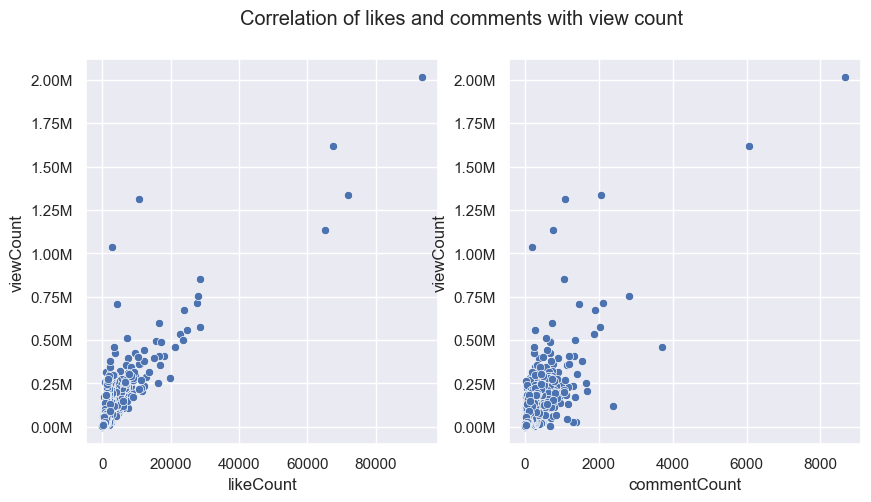

In [237]:
from matplotlib.ticker import FuncFormatter
# Create a function to format the y-axis labels in thousands
def format_thousands(value, pos):
    return f'{value/1e6:.2f}M'

fig, axes = plt.subplots(1,2, figsize=(10,5))
fig.suptitle('Correlation of likes and comments with view count')

ax1 = sns.scatterplot(ax=axes[0],x='likeCount',y='viewCount',data=video_df_copy)
# Set the x-axis formatter for 'viewCount'
ax1.yaxis.set_major_formatter(FuncFormatter(format_thousands))

ax2 = sns.scatterplot(ax=axes[1],x='commentCount',y='viewCount',data=video_df_copy)

# Set the x-axis formatter for 'viewCount'
ax2.yaxis.set_major_formatter(FuncFormatter(format_thousands))

plt.show()

### On which day of the week are the majority of videos uploaded?

Now I wanted to visualise for each channel, which days are the majority of the videos uploaded on. First thing I had to do was extract the weekday from the published date

In [148]:
#Get the Weekday of when video was uploaded
video_df_copy['day_of_upload'] = video_df_copy['publishedAt'].apply(lambda x: x.strftime('%A'))

In [242]:
video_df_copy.head()

video_id     channelTitle                 channelId publishedAt  \
0  kM_si9hmUVU  No Rolls Barred  UC5UQPZe-8v4_UP1uxi4Mv6A  2024-01-30   
1  j8nHxk-446o  No Rolls Barred  UC5UQPZe-8v4_UP1uxi4Mv6A  2024-01-27   
2  VpYApxoFtfs  No Rolls Barred  UC5UQPZe-8v4_UP1uxi4Mv6A  2024-01-23   
3  55qSVewCieM  No Rolls Barred  UC5UQPZe-8v4_UP1uxi4Mv6A  2024-01-20   
4  uiPXTlOxeeU  No Rolls Barred  UC5UQPZe-8v4_UP1uxi4Mv6A  2024-01-19   

                                               title  \
0  Let's Play SPEEDPORT and CLICKPORT | Board Gam...   
1                            Monopoly, But ZOMBIES!!   
2               Let's Play DECORUM | Board Game Club   
3                POKER, But Backwards! | House Rules   
4  WATCH Chaotic Neutral Plays Dungeons & Dragons...   

                                         description  duration caption  \
0  #AD Clickport and Speedport are both available...    3325.0   false   
1  Join the DOMMUNIST PARTY! 👉 https://shorturl.a...    5189.0   false   
2  For uncut Board Game Club episodes, exclusive ...    3079.0   false   
3  Don't forget to JOIN THE DOMMUNIST PARTY! See ...    4436.0   false   
4  Watch all five episodes of Chaotic Neutral Pla...     135.0   false   

   viewCount  likeCount  favoriteCount  commentCount  \
0      44389       2254              0           319   
1     254095      16371              0          1643   
2      82393       4184              0           282   
3     194183       8672              0           744   
4       8583        399              0            31   

                                            comments day_of_upload  \
0  [Clickport and Speedport are both available to...       Tuesday   
1  [Fill in the blank - Monopoly, But [BLANK].\nJ...      Saturday   
2  [lol I want a pirates monopoly. thievery and t...       Tuesday   
3  [Don't forget to JOIN THE DOMMUNIST PARTY! See...      Saturday   
4  [LAURIE: Watch all five episodes of Chaotic Ne...        Friday   

                                  title_no_stopwords  sentiment_score  
0  [Let's, Play, SPEEDPORT, CLICKPORT, |, Board, ...          0.18779  
1                        [Monopoly,, But, ZOMBIES!!]          0.53323  
2       [Let's, Play, DECORUM, |, Board, Game, Club]          0.13161  
3         [POKER,, But, Backwards!, |, House, Rules]          0.23388  
4  [WATCH, Chaotic, Neutral, Plays, Dungeons, &, ...          0.29104

Now to plot the number of uploads on which days

In [149]:
# Create a small table highlighting by channel by day and number of uploads
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
frequency_upload_day = video_df_copy.groupby(['channelTitle','day_of_upload'], as_index = False).size()
frequency_upload_day.index = pd.CategoricalIndex(frequency_upload_day['day_of_upload'], categories = weekdays, ordered = True)
frequency_upload_day.sort_index(inplace = True)

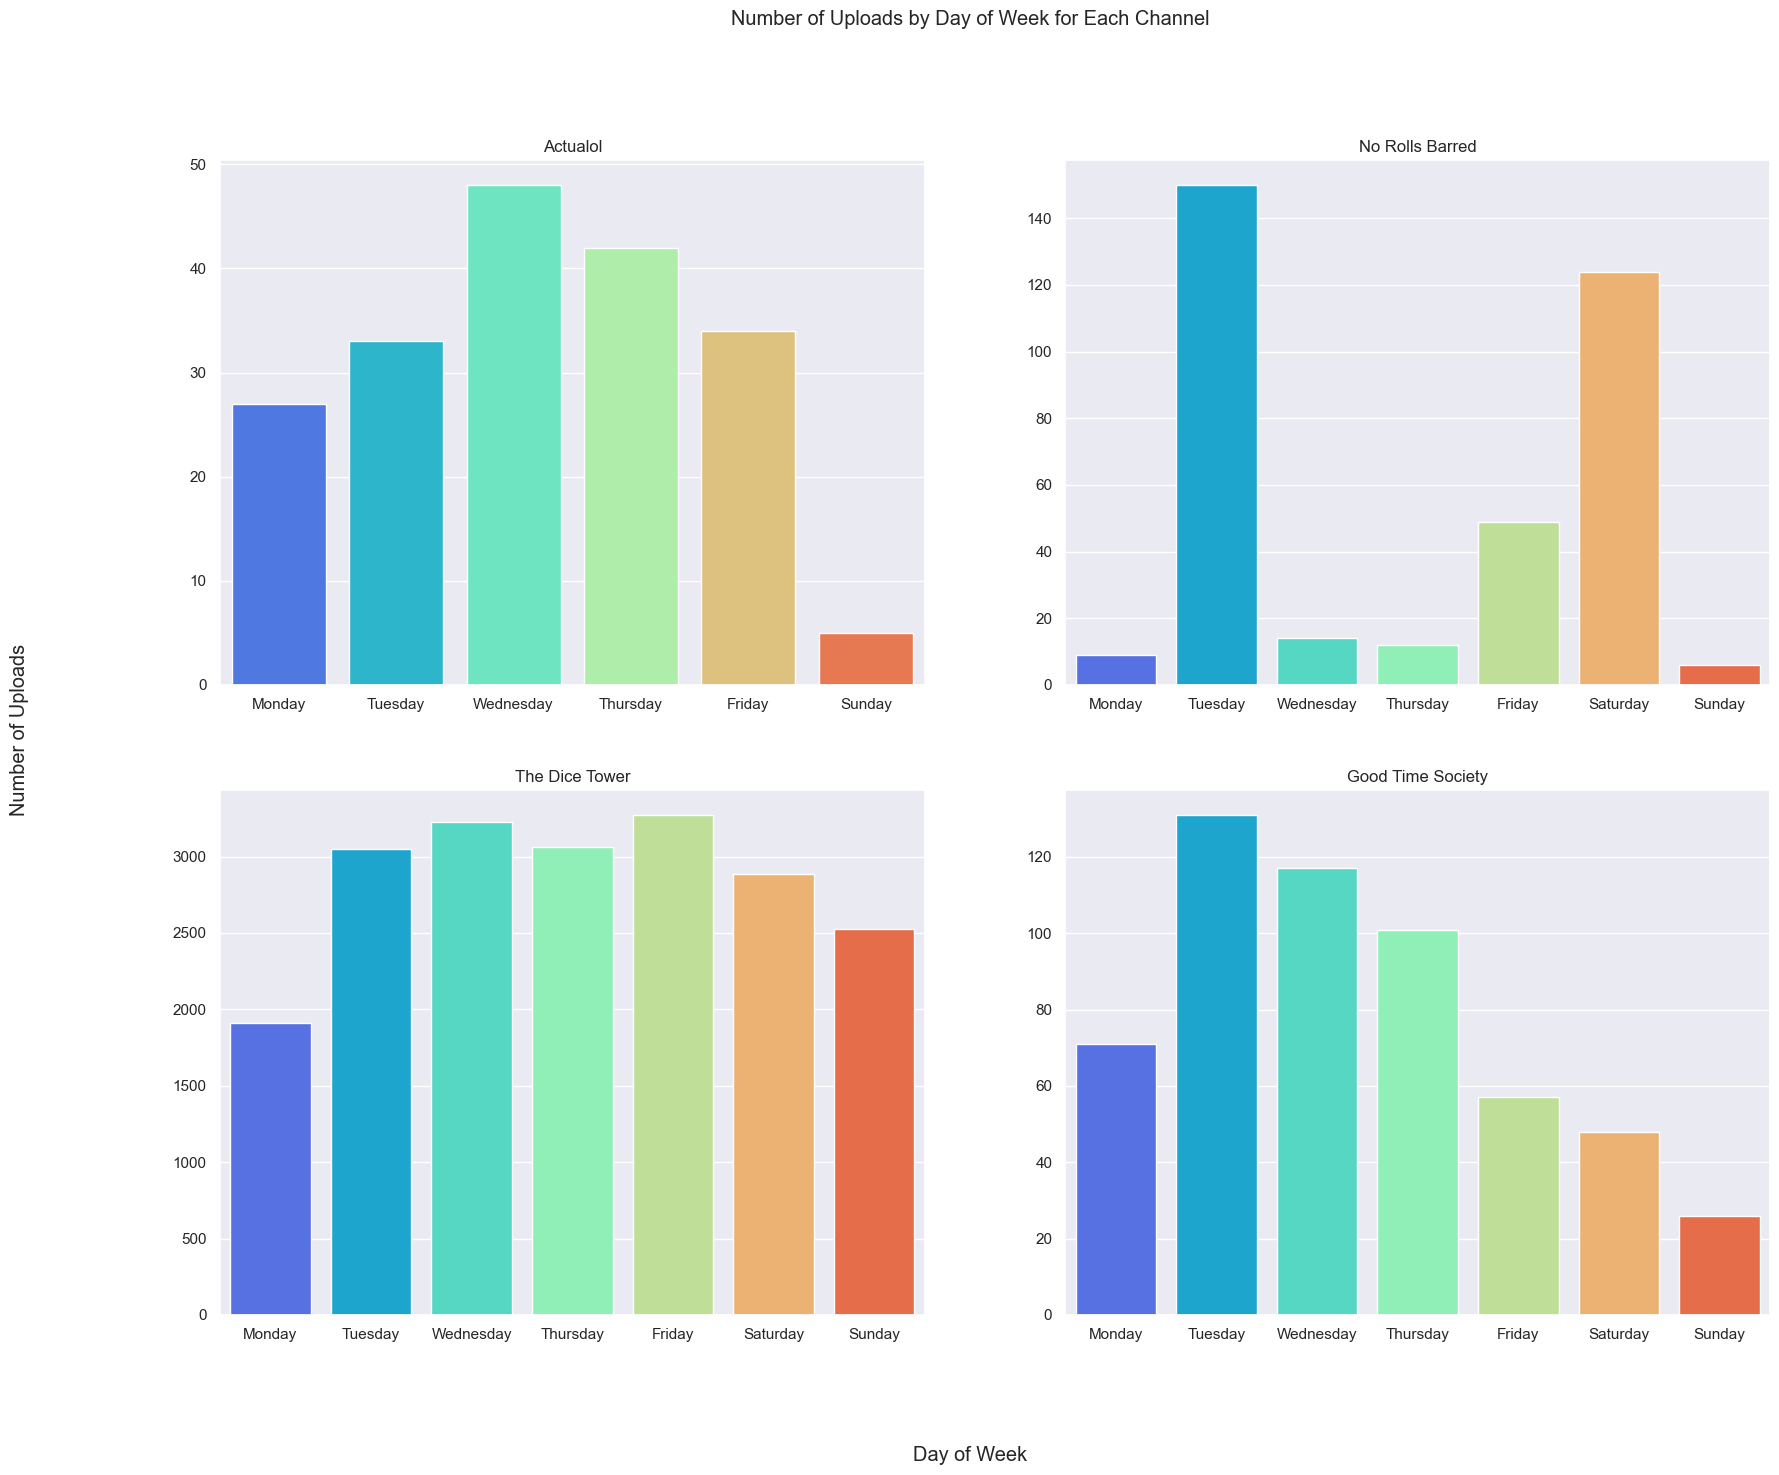

In [257]:
# Set the style for the plot (optional)

# Create a barplot using seaborn
sns.set_theme()
fig, axes = plt.subplots(2, 2,figsize=(20,15))
fig.suptitle('Number of Uploads by Day of Week for Each Channel')

ax1 = sns.barplot(ax= axes[0][0], x='day_of_upload', y='size', data=frequency_upload_day[frequency_upload_day.channelTitle == 'Actualol'], palette=("rainbow"))
ax2 = sns.barplot(ax= axes[0][1], x='day_of_upload', y='size', data=frequency_upload_day[frequency_upload_day.channelTitle == 'No Rolls Barred'], palette=("rainbow"))
ax3 = sns.barplot(ax= axes[1][0], x='day_of_upload', y='size', data=frequency_upload_day[frequency_upload_day.channelTitle == 'The Dice Tower'], palette=("rainbow"))
ax4 = sns.barplot(ax= axes[1][1], x='day_of_upload', y='size', data=frequency_upload_day[frequency_upload_day.channelTitle == 'Good Time Society'], palette=("rainbow"))

ax1.set_xlabel(None)
ax1.set_ylabel(None)
ax2.set_xlabel(None)
ax2.set_ylabel(None)
ax3.set_xlabel(None)
ax3.set_ylabel(None)
ax4.set_xlabel(None)
ax4.set_ylabel(None)

ax1.set_title('Actualol')
ax2.set_title('No Rolls Barred')
ax3.set_title('The Dice Tower')
ax4.set_title('Good Time Society')


# Set the title and labels
# ax.set_title('Number of Uploads by Day of Week for Each Channel')
fig.supxlabel('Day of Week')
fig.supylabel('Number of Uploads')



# Show the plot
plt.show()

From the above visualisation, its interesting to see the different variety in the upload schedule of diiferent channels. For example Actualol mostly uploads their videos on weekdays, especially on Wednesday being the peak and closely followed by Thursday. Barely any videos are uploaded on the weekend, with just a few on Sunday. For The Dice Tower its a bit different with there quite being of an even spread in which days videos are uploaded, for example Tuesday, Wednesday, Thursday, Friday & Saturday all have similar number of uploads in the channels history. This could be as a result of change of upload schedule over time with The Dice Tower first upload in the year 2014. On the other hand, No Rolls Barred is the most recent channel to be set up (in 2020) compared to the other 4, and its upload schedule is distinct, with the majority of uploads occuring on Tuesday & Saturday. Finally, for Good Time Society, most uploads occured on Tuesday and then history of uploads drop each day.

In [263]:
print('Actualol: ' , video_df_copy[video_df_copy.channelTitle == 'Actualol'].publishedAt.min())
print('No Rolls Barred: ' , video_df_copy[video_df_copy.channelTitle == 'No Rolls Barred'].publishedAt.min())
print('The Dice Tower: ' , video_df_copy[video_df_copy.channelTitle == 'The Dice Tower'].publishedAt.min())
print('Good Time Society: ' , video_df_copy[video_df_copy.channelTitle == 'Good Time Society'].publishedAt.min())


Actualol:  2015-07-02 00:00:00
No Rolls Barred:  2020-09-26 00:00:00
The Dice Tower:  2014-04-04 00:00:00
Good Time Society:  2016-01-26 00:00:00


## Sentiment Analysis

Now I wanted to get a feel of the polarity for what the channels where about. Obviously I know these channels are about board games but it would be good to visualise the more frequently used word in the title of the videos. As we can see the terms like "Board", "Game", "Review", "Unboxing", "Dice", "Play" are common themes with board game lore and show up in lots of the videos titles

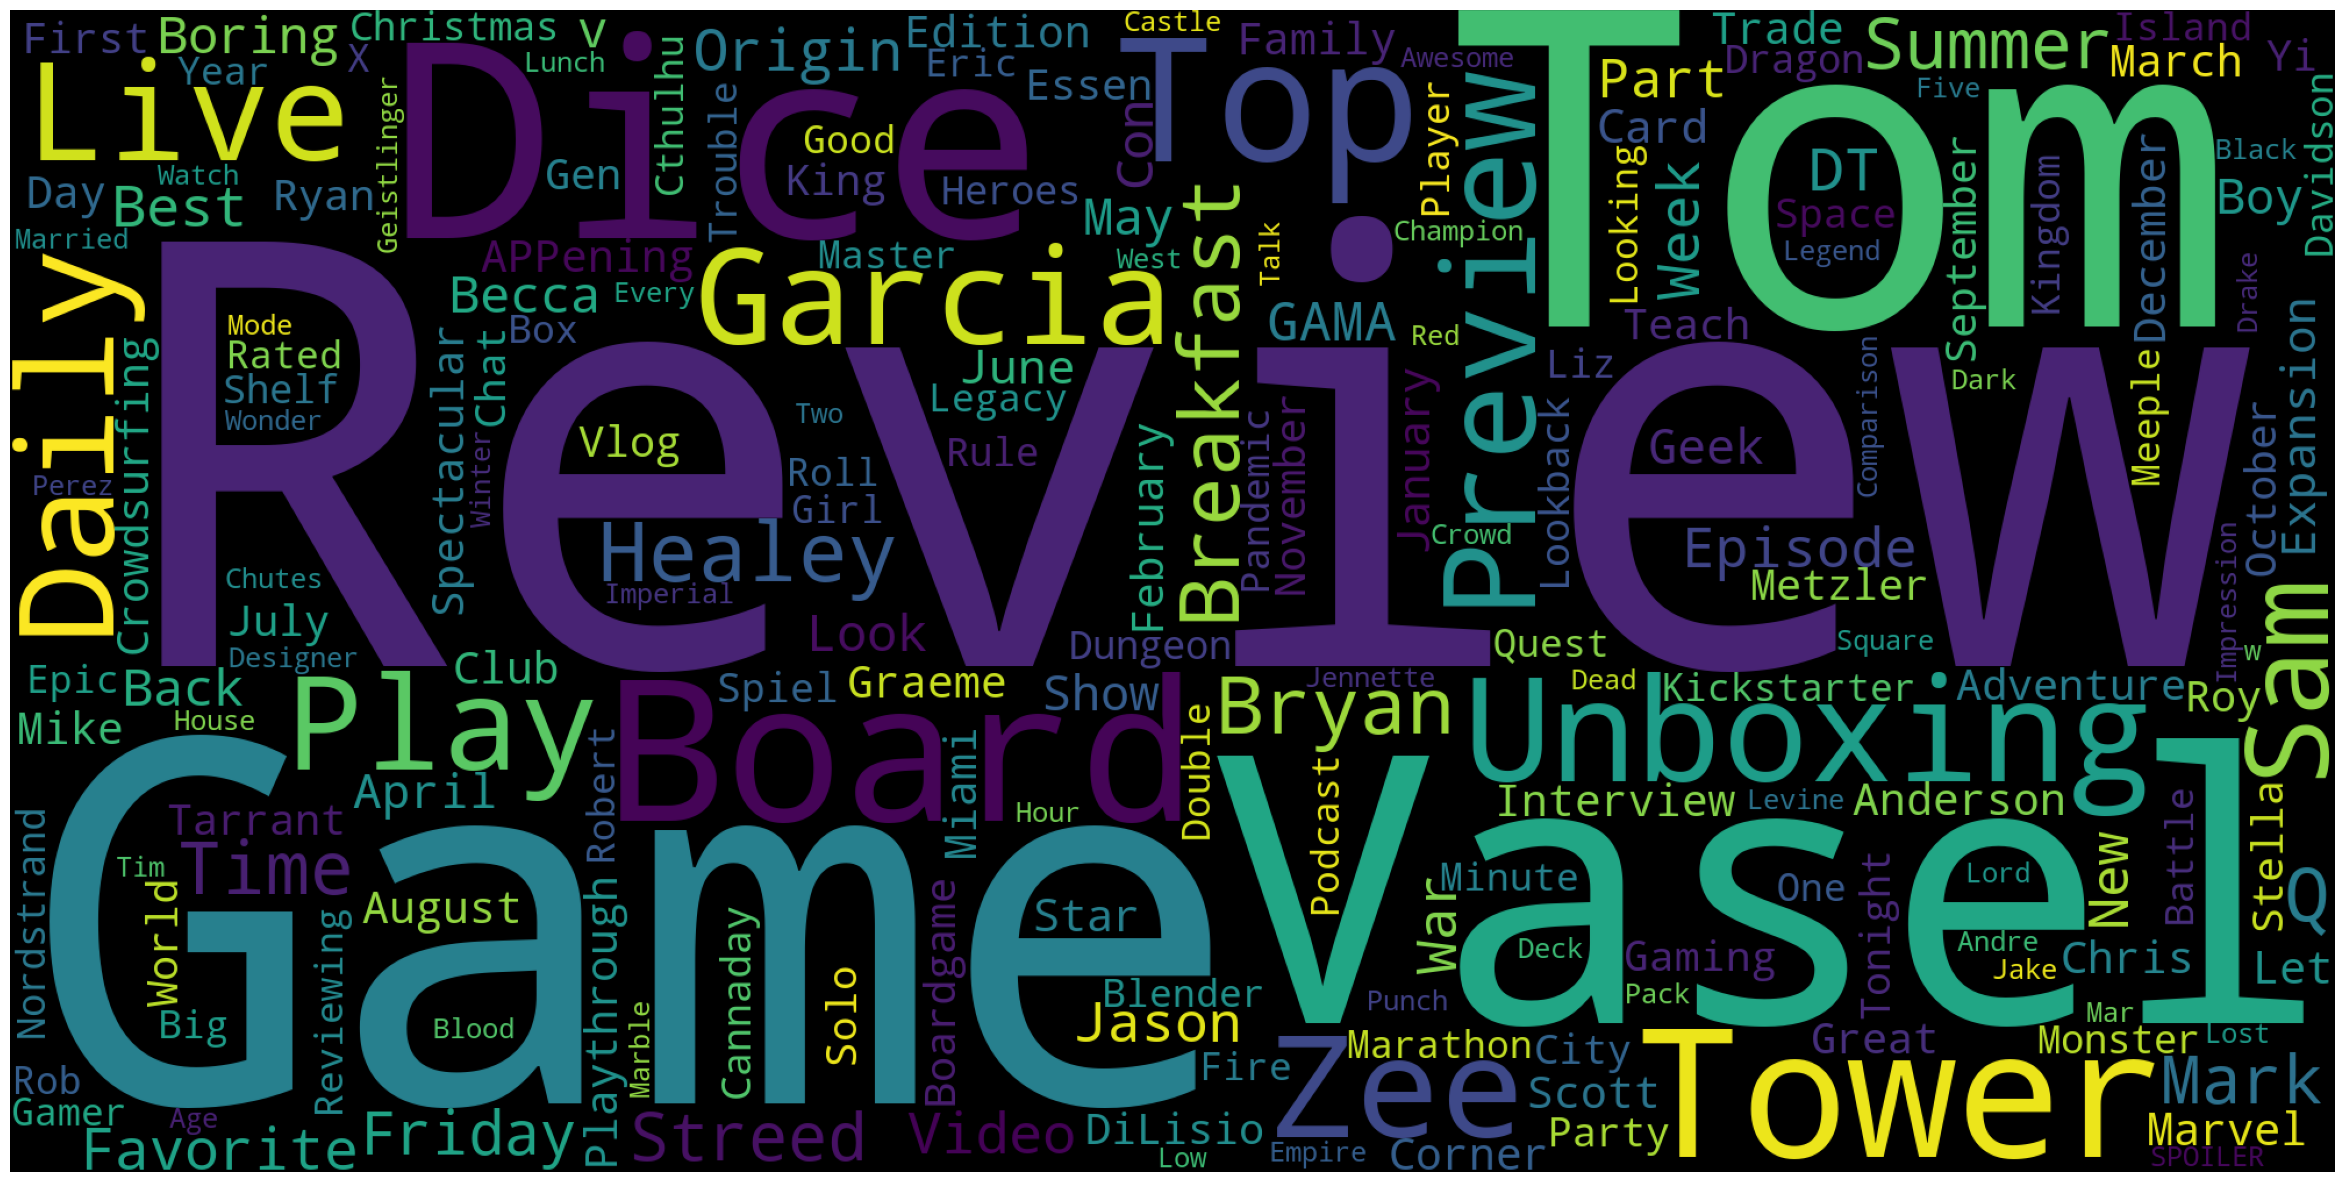

In [153]:
stop_words = set(stopwords.words('english'))
video_df_copy['title_no_stopwords'] = video_df_copy['title'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in video_df_copy['title_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words) 

def plot_cloud(wordcloud):
    plt.figure(figsize=(30, 20))
    plt.imshow(wordcloud) 
    plt.axis("off");

wordcloud = WordCloud(width = 2000, height = 1000, random_state=1, background_color='black', 
                      colormap='viridis', collocations=False).generate(all_words_str)
plot_cloud(wordcloud)

Next up I wanted to calculate the sentiment scores based of the comments of each video, that way I could get somewhat of a sentiment of what the video was like. Youtube doesnt show number of dislikes anymore so getting the sentiment of the comments section can be somewhat helpful in understanding a broader picture of how a video did. But take into account, comments are subjective and shouldnt be taken literally as they differ from person to person.

I couldnt retrieve all the comments for all videos as I exceeded my youtube API quota, so for the videos that dont have comments I scored a neutral sentiment of 0

In [169]:
# I couldnt retrieve all the comments for each vid as I exceeded my youtube API quota so for the videos that dont have comments I scored a neutral sentiment of 0
video_df_copy['comments'].fillna('the', inplace =True)

In [170]:
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

# Create a SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Function to get average sentiment scores for a list of comments
def analyze_sentiment(comment_list):
    # Calculate sentiment scores for each comment
    sentiment_scores = [sia.polarity_scores(comment)['compound'] for comment in comment_list]
    # Calculate the average sentiment score
    if len(sentiment_scores) == 0:
        average_sentiment = 0
    else:
        average_sentiment = sum(sentiment_scores) / len(sentiment_scores)
    return average_sentiment

# Apply sentiment analysis to 'comments' column
video_df_copy['sentiment_score'] = video_df_copy['comments'].apply(analyze_sentiment)

In [264]:
# Display the DataFrame with sentiment analysis results
video_df_copy.head()

video_id     channelTitle                 channelId publishedAt  \
0  kM_si9hmUVU  No Rolls Barred  UC5UQPZe-8v4_UP1uxi4Mv6A  2024-01-30   
1  j8nHxk-446o  No Rolls Barred  UC5UQPZe-8v4_UP1uxi4Mv6A  2024-01-27   
2  VpYApxoFtfs  No Rolls Barred  UC5UQPZe-8v4_UP1uxi4Mv6A  2024-01-23   
3  55qSVewCieM  No Rolls Barred  UC5UQPZe-8v4_UP1uxi4Mv6A  2024-01-20   
4  uiPXTlOxeeU  No Rolls Barred  UC5UQPZe-8v4_UP1uxi4Mv6A  2024-01-19   

                                               title  \
0  Let's Play SPEEDPORT and CLICKPORT | Board Gam...   
1                            Monopoly, But ZOMBIES!!   
2               Let's Play DECORUM | Board Game Club   
3                POKER, But Backwards! | House Rules   
4  WATCH Chaotic Neutral Plays Dungeons & Dragons...   

                                         description  duration caption  \
0  #AD Clickport and Speedport are both available...    3325.0   false   
1  Join the DOMMUNIST PARTY! 👉 https://shorturl.a...    5189.0   false   
2  For uncut Board Game Club episodes, exclusive ...    3079.0   false   
3  Don't forget to JOIN THE DOMMUNIST PARTY! See ...    4436.0   false   
4  Watch all five episodes of Chaotic Neutral Pla...     135.0   false   

   viewCount  likeCount  favoriteCount  commentCount  \
0      44389       2254              0           319   
1     254095      16371              0          1643   
2      82393       4184              0           282   
3     194183       8672              0           744   
4       8583        399              0            31   

                                            comments day_of_upload  \
0  [Clickport and Speedport are both available to...       Tuesday   
1  [Fill in the blank - Monopoly, But [BLANK].\nJ...      Saturday   
2  [lol I want a pirates monopoly. thievery and t...       Tuesday   
3  [Don't forget to JOIN THE DOMMUNIST PARTY! See...      Saturday   
4  [LAURIE: Watch all five episodes of Chaotic Ne...        Friday   

                                  title_no_stopwords  sentiment_score  
0  [Let's, Play, SPEEDPORT, CLICKPORT, |, Board, ...          0.18779  
1                        [Monopoly,, But, ZOMBIES!!]          0.53323  
2       [Let's, Play, DECORUM, |, Board, Game, Club]          0.13161  
3         [POKER,, But, Backwards!, |, House, Rules]          0.23388  
4  [WATCH, Chaotic, Neutral, Plays, Dungeons, &, ...          0.29104

In [229]:
top10_sent = video_df_copy.sort_values('sentiment_score', ascending = False).head(10)


In [228]:
top10 = video_df_copy.sort_values('viewCount', ascending = False).iloc[0:10]


### Top 10 videos viewed sentiment score vs Top 10 videos based on their sentiment score

From the plots below, it was interesting to find that whilst the top 10 viewed videos mostly had a positve sentiment, the sentiment score wasnt as high as those compared to the top 10 videos based of sentiment score. This could be the more views a video accumualtes, the more comments it gets leading to a larger diverse comments environment.

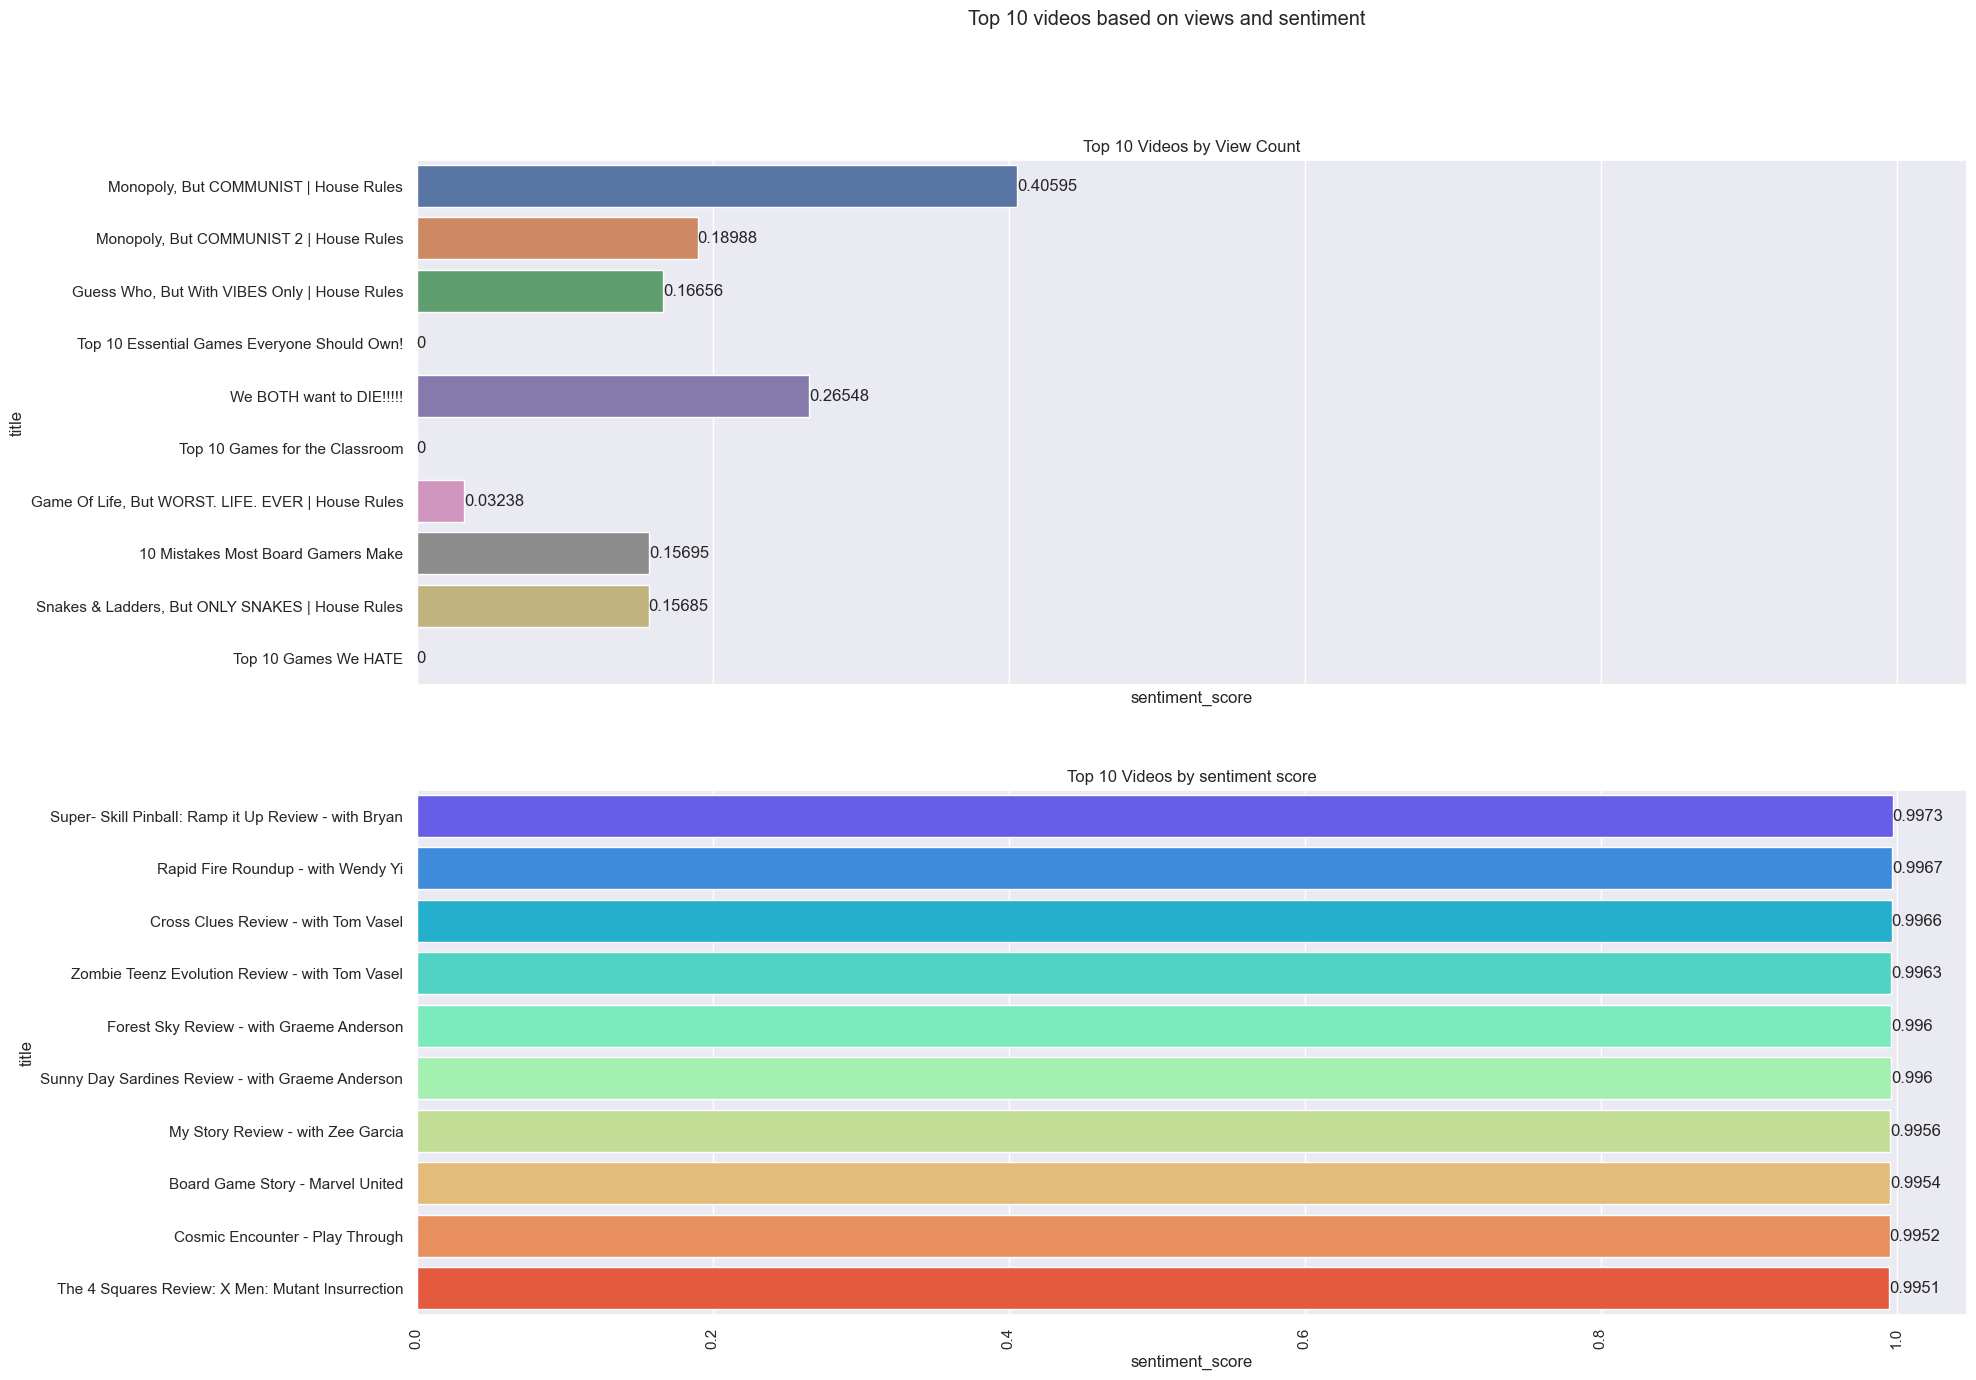

In [176]:
fig, axes = plt.subplots(2, 1,figsize=(20,15), sharex=True)
fig.suptitle('Top 10 videos based on views and sentiment')

ax1 = sns.barplot(ax= axes[0], x='sentiment_score', y='title', data = top10)
# Set the y-axis formatter for 'viewCount'
ax2 = sns.barplot(ax= axes[1], x='sentiment_score', y='title', data = top10_sent, palette=("rainbow"))
ax1.bar_label(ax1.containers[0])
ax1.tick_params(axis='x', rotation=90)
ax2.bar_label(ax2.containers[0])

ax2.tick_params(axis='x', rotation=90)

ax1.set_title('Top 10 Videos by View Count')

ax2.set_title('Top 10 Videos by sentiment score')



plt.show()

When comparing the top 10 viewed videos vs top 10 videos based on sentiment, it was clear there was a large difference in the mean view count, from 1147724 vs 10770

In [177]:
loo = pd.DataFrame(top10[['title','viewCount','sentiment_score','publishedAt','duration']])
loo=loo.reset_index(drop=True)
print(f'mean view count: {loo.viewCount.mean():.0f}')
print(f'mean sentiment score: {loo.sentiment_score.mean():.2f}')
print(f'mean duration: {loo.duration.mean():.0f}')

mean view count: 1147724
mean sentiment score: 0.14
mean duration: 3068


In [179]:
lool = pd.DataFrame(top10_sent[['title','viewCount','sentiment_score','publishedAt','duration']])
lool=lool.reset_index(drop=True)
print(f'mean view count: {lool.viewCount.mean():.0f}')
print(f'mean sentiment score: {lool.sentiment_score.mean():.2f}')
print(f'mean duration: {lool.duration.mean():.0f}')

mean view count: 10770
mean sentiment score: 1.00
mean duration: 1094


In [180]:
loo

title  viewCount  \
0              Monopoly, But COMMUNIST | House Rules    2017382   
1            Monopoly, But COMMUNIST 2 | House Rules    1617635   
2       Guess Who, But With VIBES Only | House Rules    1337620   
3        Top 10 Essential Games Everyone Should Own!    1311861   
4                           We BOTH want to DIE!!!!!    1136169   
5                     Top 10 Games for the Classroom    1035424   
6  Game Of Life, But WORST. LIFE. EVER | House Rules     848859   
7                 10 Mistakes Most Board Gamers Make     752547   
8    Snakes & Ladders, But ONLY SNAKES | House Rules     712311   
9                               Top 10 Games We HATE     707437   

   sentiment_score publishedAt  duration  
0          0.40595  2023-06-17    3649.0  
1          0.18988  2023-09-02    6052.0  
2          0.16656  2022-04-30    1907.0  
3          0.00000  2016-10-13    3302.0  
4          0.26548  2023-07-11      58.0  
5          0.00000  2014-06-26    2847.0  
6          0.03238  2023-04-08    3874.0  
7          0.15695  2022-02-04    1144.0  
8          0.15685  2023-05-13    3573.0  
9          0.00000  2015-02-20    4273.0

In [181]:
lool

title  viewCount  \
0  Super- Skill Pinball: Ramp it Up Review - with...       3163   
1                 Rapid Fire Roundup - with Wendy Yi       8137   
2                Cross Clues Review - with Tom Vasel      11840   
3     Zombie Teenz Evolution Review - with Tom Vasel      19672   
4           Forest Sky Review - with Graeme Anderson       2270   
5   Sunny Day Sardines Review - with Graeme Anderson       1770   
6                  My Story Review - with Zee Garcia       5448   
7                   Board Game Story - Marvel United       2888   
8                    Cosmic Encounter - Play Through      24419   
9   The 4 Squares Review: X Men: Mutant Insurrection      28091   

   sentiment_score publishedAt  duration  
0           0.9973  2021-11-23     616.0  
1           0.9967  2023-03-03     620.0  
2           0.9966  2020-04-25     480.0  
3           0.9963  2021-02-07     586.0  
4           0.9960  2023-01-03     455.0  
5           0.9960  2022-10-13     358.0  
6           0.9956  2020-10-18    1018.0  
7           0.9954  2022-01-26     153.0  
8           0.9952  2021-04-29    4991.0  
9           0.9951  2021-02-18    1659.0

### Common words in the positive sentiment videos

Videos with a mean sentiment score over 0.05 where deemed to have a positive sentiment. The wordcloud below identfies common words within the positive sentiment videos such as "game", "great", "love", "thank", "favorite", "good",e.t.c all thematic words indicating of a consensus of a positive video

In [227]:
positive_sent = video_df_copy.query('sentiment_score > 0.05').sort_values('sentiment_score', ascending = False)
negative = video_df_copy.query('sentiment_score < -0.05').sort_values('sentiment_score', ascending = False)



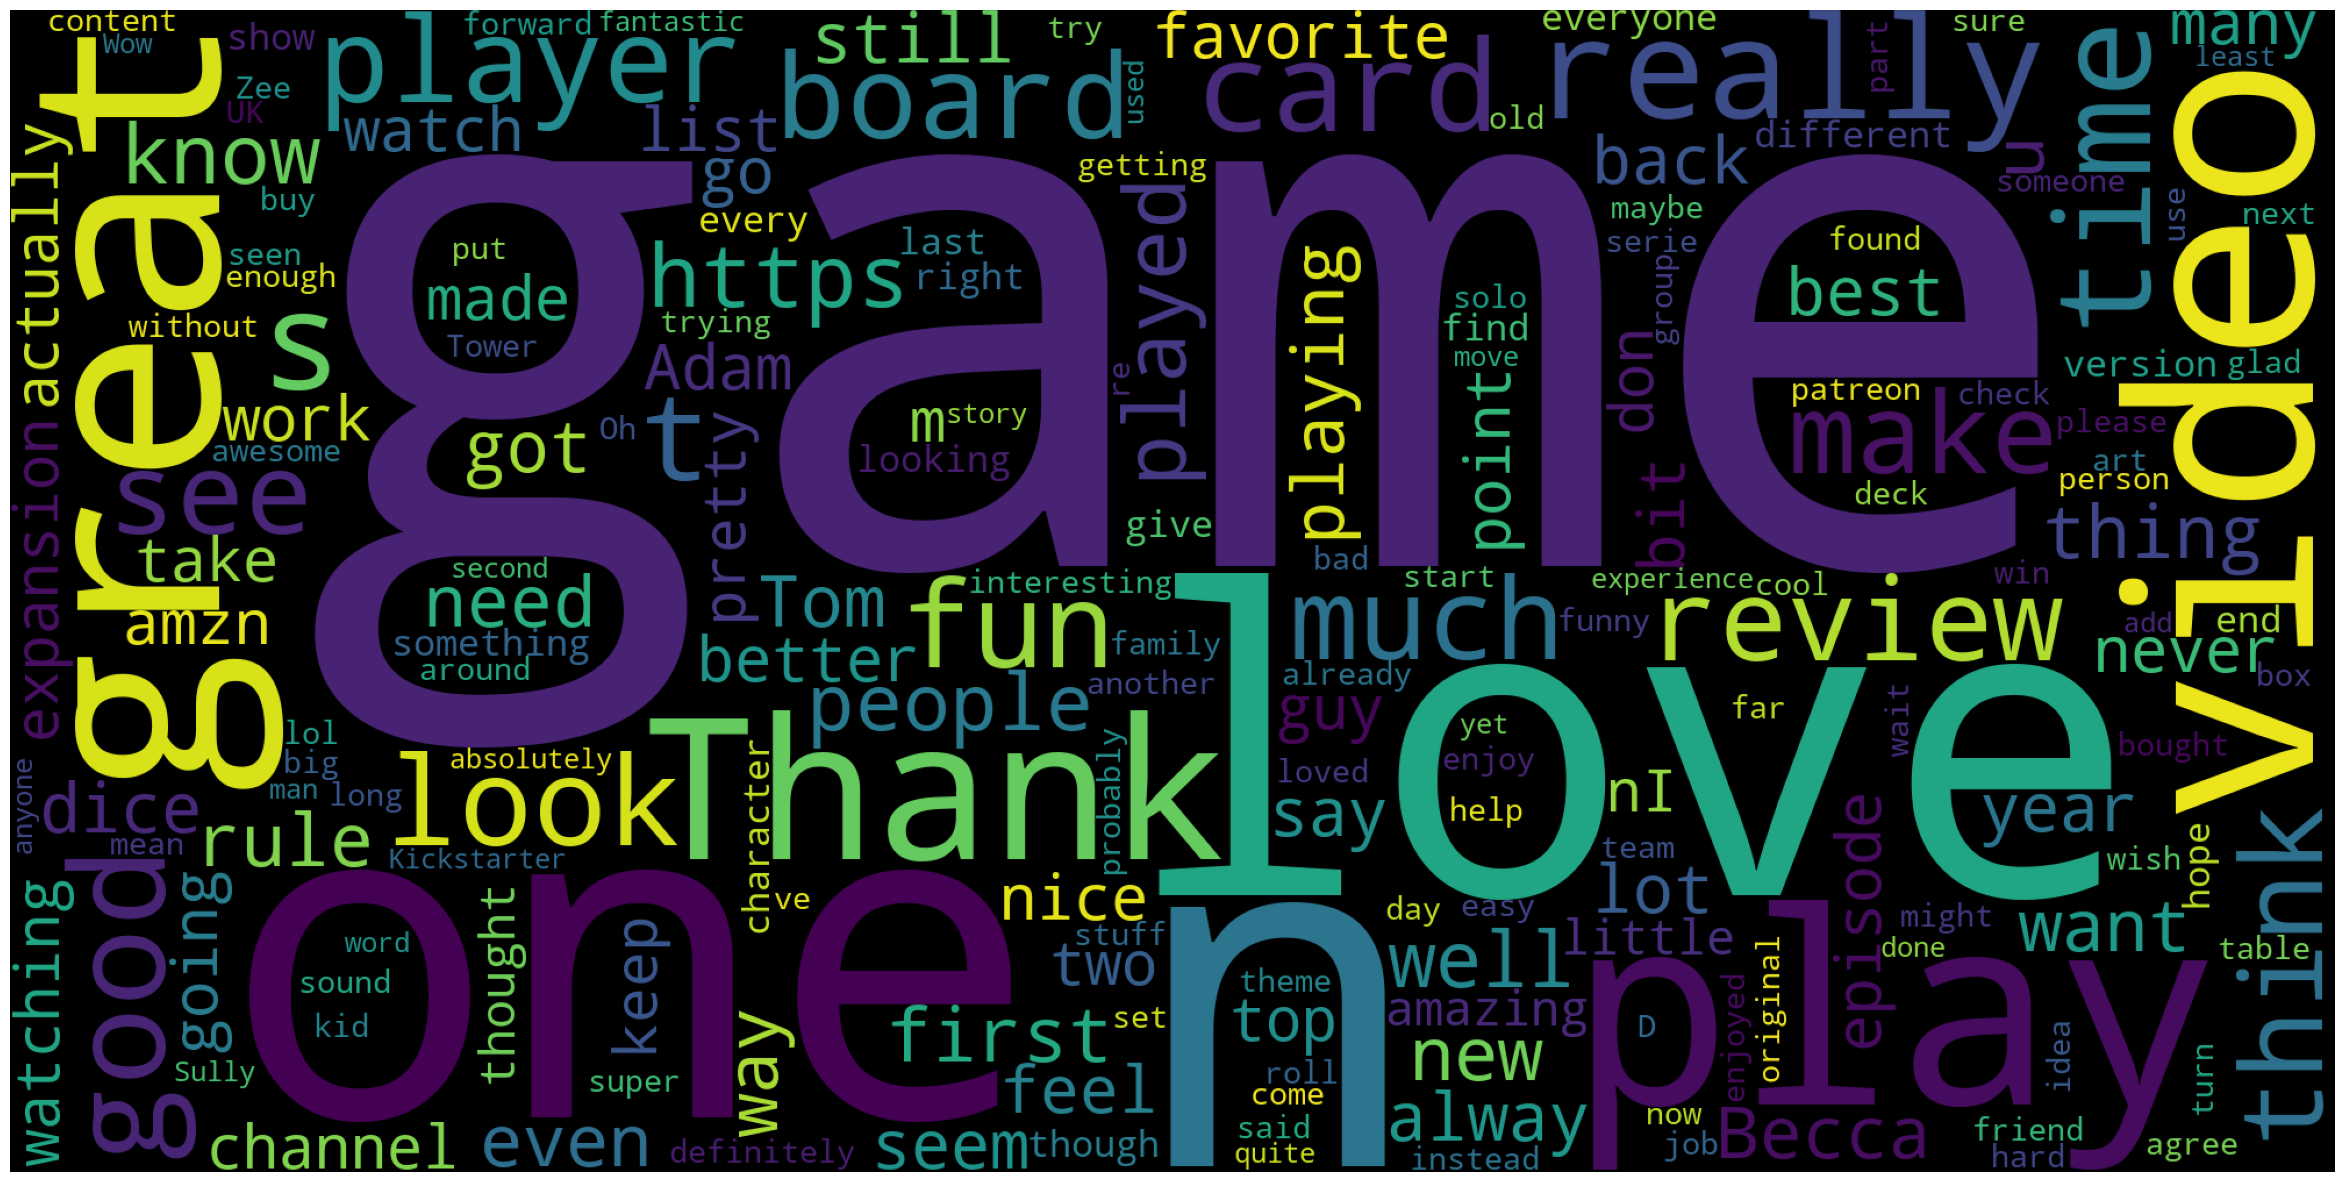

In [187]:
stop_words = set(stopwords.words('english'))
positive_sent['comments_no_stopwords'] = positive_sent['comments'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in positive_sent['comments_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words) 

def plot_cloud(wordcloud):
    plt.figure(figsize=(30, 20))
    plt.imshow(wordcloud) 
    plt.axis("off");

wordcloud = WordCloud(width = 2000, height = 1000, random_state=1, background_color='black', 
                      colormap='viridis', collocations=False).generate(all_words_str)
plot_cloud(wordcloud)

### Decrypto??? What is the vibe on this game

One of the games which I have heard for a long time but havent played is Decrypto. From the 4 channels I wanted to see if they made videos on this game and get a feel of the sentiment. I was happy to see out of all the videos for Decrypto, not one had a mean negative sentiment score, with 6 out of the 8 videos all scoring a positive sentiment whilst the other 2 were neutral. Maybe once I too watch these videos I might purchase the game.

Again I made a word cloud for videos related to Decrypto and mostly positive words were frequently shown in the comments as expected.

In [265]:
decrypto = video_df_copy.query('title.str.contains("decrypto", case=False, na=False)')
decrypto

video_id       channelTitle                 channelId publishedAt  \
113    -cGTcHh5_6A    No Rolls Barred  UC5UQPZe-8v4_UP1uxi4Mv6A  2022-12-13   
276    d81DxDuS6Ok    No Rolls Barred  UC5UQPZe-8v4_UP1uxi4Mv6A  2021-05-21   
482    4fq7up76-to           Actualol  UCO-hn9MJOu7pOUdGSabKGvA  2018-05-14   
4656   lqcYFTGaTo4     The Dice Tower  UCiwBbXQlljGjKtKhcdMliRA  2021-10-01   
11907  aLQaumhIVIQ     The Dice Tower  UCiwBbXQlljGjKtKhcdMliRA  2018-08-07   
13600  NNJUfa-8saQ     The Dice Tower  UCiwBbXQlljGjKtKhcdMliRA  2017-12-30   
20717  vIO_Ylh0-v0  Good Time Society  UCBRTbbK-avyRJSSJ2GyHs_w  2021-10-21   
20957  L2api-D2CBY  Good Time Society  UCBRTbbK-avyRJSSJ2GyHs_w  2020-04-15   

                                                   title  \
113                Let's Play DECRYPTO | Board Game Club   
276             Let's Play... DECRYPTO | Board Game Club   
482    Now Playing: Decrypto, Skyward, Junta Las Cart...   
4656         Decrypto Laser Drive Review - with Chris Yi   
11907                        Decrypto Review - with Anna   
13600                  Decrypto Review - with Zee Garcia   
20717  Decrypto Board Game Play Through! | Becca Scot...   
20957  How to Play Decrypto | Good Time Society with ...   

                                             description  duration caption  \
113    For uncut Board Game Club episodes, exclusive ...    3054.0   false   
276    Let's get sleuthing! The gang play Decrypto, w...    3885.0   false   
482    I talk about the board games I've been playing...    1417.0   false   
4656   Chris Yi takes a look at the expansion to a cl...     501.0   false   
11907  Anna checks out this popular deduction and par...     980.0   false   
13600  Zee takes a look at this work deduction game o...     861.0    true   
20717  We played Decrypto with Quackalope, Board Game...    2277.0   false   
20957  Check out this complex and captivating party g...     304.0   false   

       viewCount  likeCount  favoriteCount  commentCount  \
113       137739       5024              0           462   
276        50259       1441              0           116   
482         5323        155              0            20   
4656        4639        111              0             4   
11907       2166         31              0             8   
13600      45213        441              0            46   
20717      11398        207              0            17   
20957       5753        176              0            12   

                                                comments day_of_upload  \
113    [For uncut Board Game Club episodes, exclusive...       Tuesday   
276    ["i was an extra in harry potter"\n- every mil...        Friday   
482    [What happened to decrypto for 2018? Is it sti...        Monday   
4656                      [You look like gameovergreggy]        Friday   
11907                                                the       Tuesday   
13600                                                the      Saturday   
20717  [14:55 dodgy behaviour intercepted! :-P, This ...      Thursday   
20957  [We should collaborate as a Team!, JESUS CHRIS...     Wednesday   

                                      title_no_stopwords  sentiment_score  
113        [Let's, Play, DECRYPTO, |, Board, Game, Club]          0.24310  
276     [Let's, Play..., DECRYPTO, |, Board, Game, Club]          0.09641  
482    [Now, Playing:, Decrypto,, Skyward,, Junta, La...          0.56290  
4656      [Decrypto, Laser, Drive, Review, -, Chris, Yi]          0.36120  
11907                        [Decrypto, Review, -, Anna]          0.00000  
13600                 [Decrypto, Review, -, Zee, Garcia]          0.00000  
20717  [Decrypto, Board, Game, Play, Through!, |, Bec...          0.47633  
20957  [How, Play, Decrypto, |, Good, Time, Society, ...          0.23532

/var/folders/ny/2krvw75x093306cvxctrhdzh0000gn/T/ipykernel_44072/2424701323.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  decrypto['comments_no_stopwords'] = decrypto['comments'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])


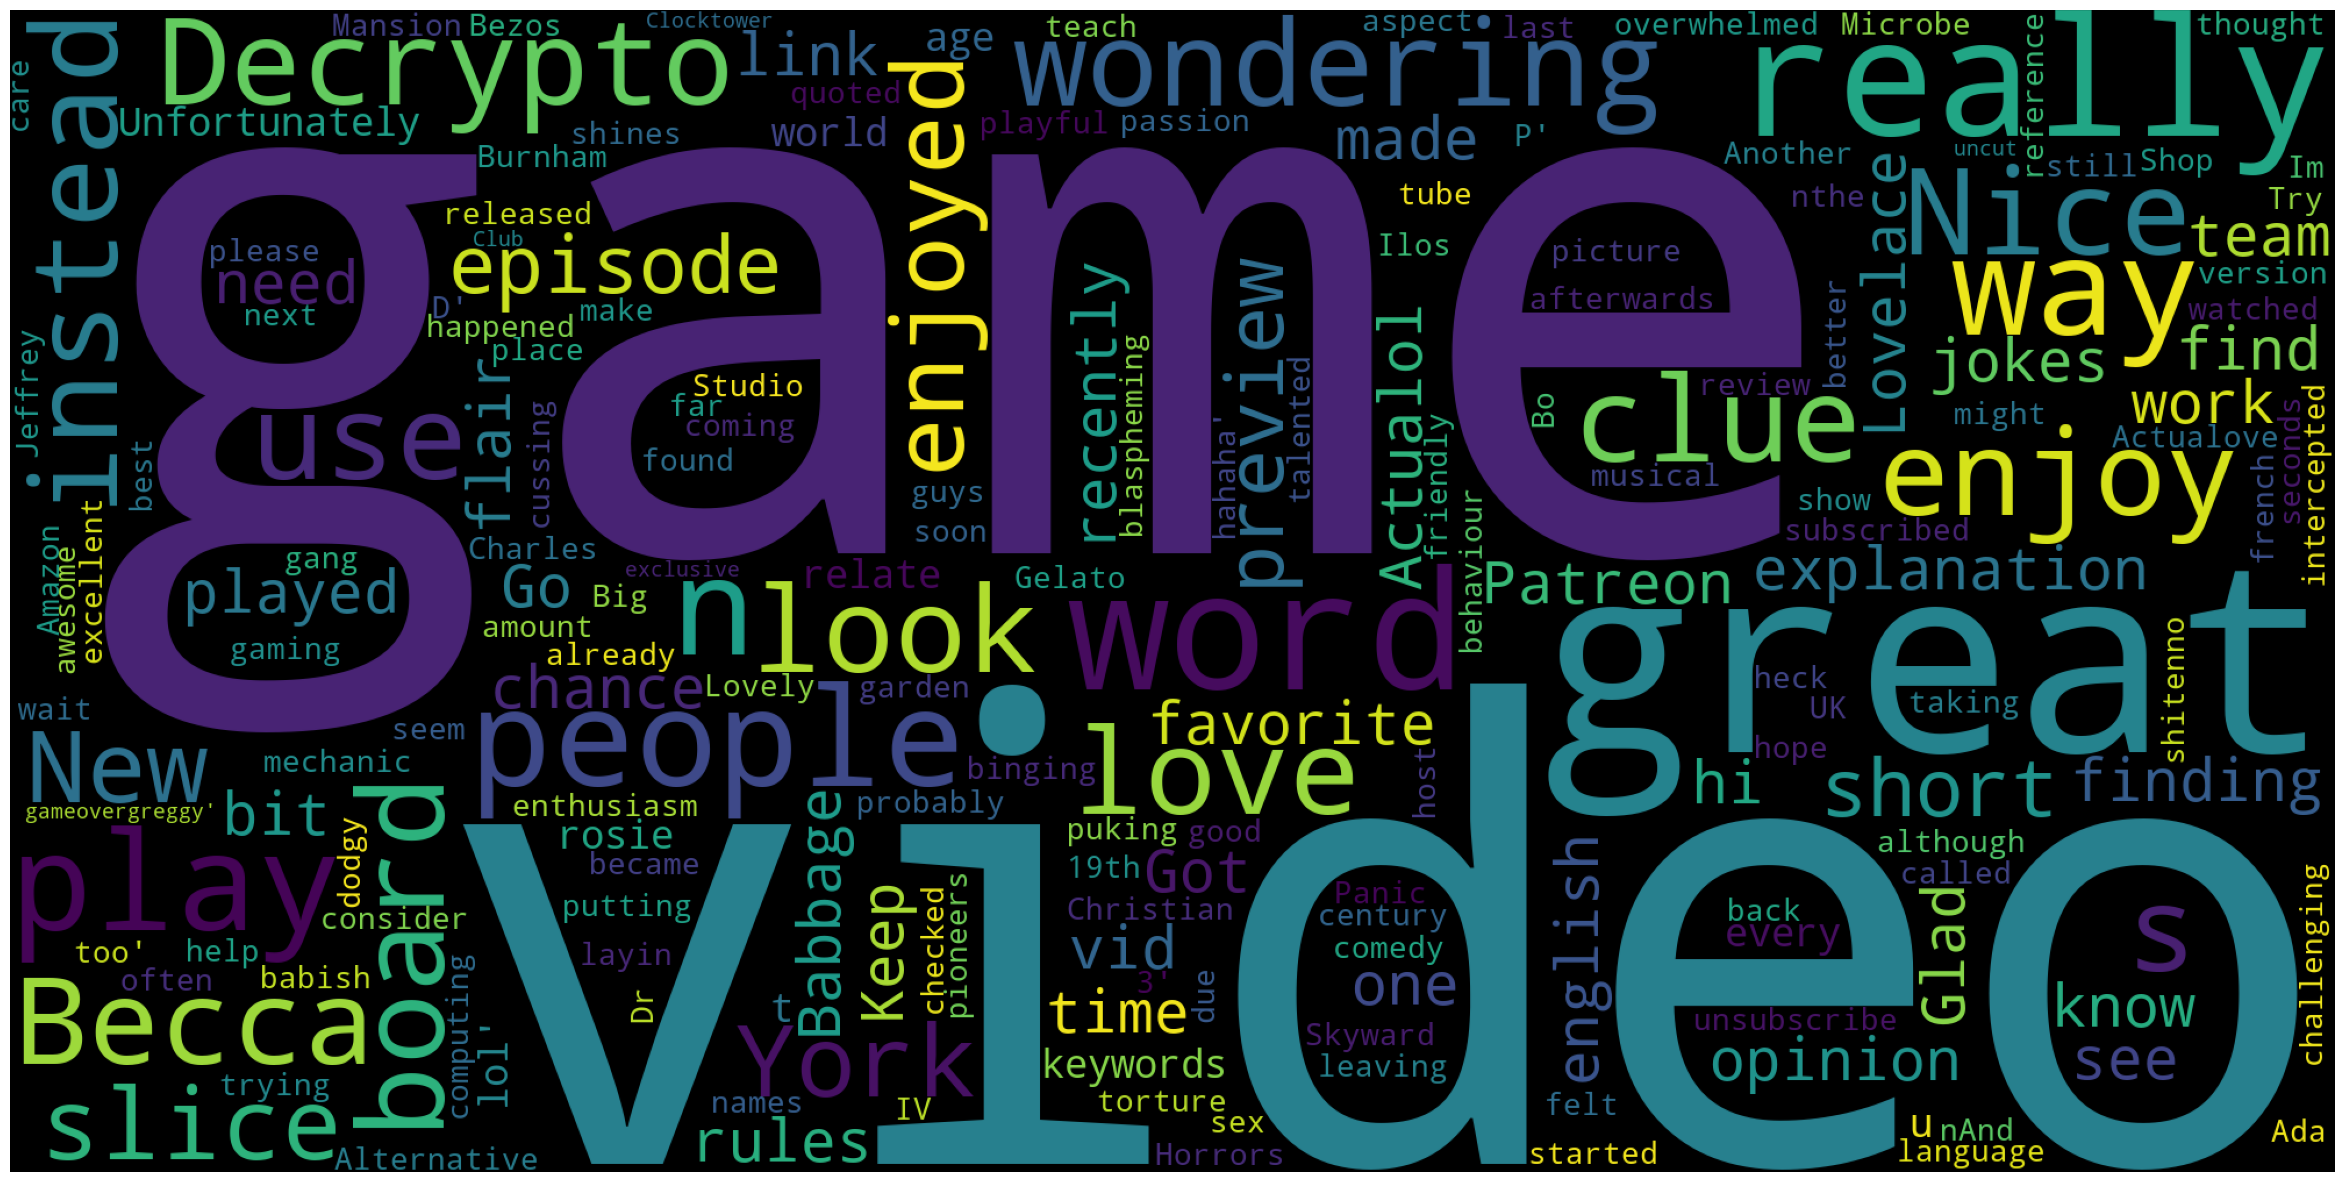

In [198]:
stop_words = set(stopwords.words('english'))
decrypto['comments_no_stopwords'] = decrypto['comments'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in decrypto['comments_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words) 

def plot_cloud(wordcloud):
    plt.figure(figsize=(30, 20))
    plt.imshow(wordcloud) 
    plt.axis("off");

wordcloud = WordCloud(width = 2000, height = 1000, random_state=1, background_color='black', 
                      colormap='viridis', collocations=False).generate(all_words_str)
plot_cloud(wordcloud)

# 4. Conclusion: Chosing 2 channels to follow

Out of the four channels analysed, I now wanted to pick two channels to follow. 

In [203]:
actualol = video_df_copy.query('channelTitle == "Actualol"').reset_index(drop=True)
good_time_society = video_df_copy.query('channelTitle == "Good Time Society"').reset_index(drop=True)
dice_tower = video_df_copy.query('channelTitle == "The Dice Tower"').reset_index(drop=True)
no_rolls_bared = video_df_copy.query('channelTitle == "No Rolls Barred"').reset_index(drop=True)

In [ ]:
def retrieve_stats(dfs):
    stats_list = []
    
    for df in dfs:
        stats_dict = {
            'channel_name': df['channelTitle'].iloc[0],
            'mean_view_count': int(round(df['viewCount'].mean(),0)),
            'mean_sentiment_score': round(df['sentiment_score'].mean(),2),
            'mean_duration': int(round(df['duration'].mean(),0))
        }
        stats_list.append(stats_dict)

    # Convert the list of dictionaries into a DataFrame
    stats_df = pd.DataFrame(stats_list)
    
    return stats_df

ch_stats = retrieve_stats([actualol,good_time_society, no_rolls_bared, dice_tower])


In [ ]:
merged_stats = pd.merge(stats, ch_stats, on='channel_name')


In [266]:
merged_stats

channel_name                                        description  \
0  Good Time Society  Welcome to Good Time Society! Stick around awh...   
1     The Dice Tower  Video reviews of games, top 10 lists, live pla...   
2    No Rolls Barred  Welcome to the Official No Rolls Barred YouTub...   
3           Actualol         Board game reviews with a sense of humour.   

   total_views  total_uploads  total_subscribers channel_unique_playlist_id  \
0      4559173            553              58100   UUBRTbbK-avyRJSSJ2GyHs_w   
1    332478165          23180             334000   UUiwBbXQlljGjKtKhcdMliRA   
2     57216291            365             320000   UU5UQPZe-8v4_UP1uxi4Mv6A   
3      8584495            189             106000   UUO-hn9MJOu7pOUdGSabKGvA   

   mean_view_count  mean_sentiment_score  mean_duration  
0             8220                  0.30           3781  
1            13604                  0.15           1565  
2           157421                  0.20           3931  
3            45452                  0.45           1386

### Insights



Initially, what puts me off about the dice tower channel is that although it has the highest subscriber count and highest number of uploads its mean view count is the second lowest and has the lowest positive sentiment score out of the 4. 

Despite having a substantial subscriber count and a significant number of uploads, the lower mean view count and sentiment score could suggest a few possibilities:

* **Diverse Content**: The channel may have a wide variety of content, and some videos may resonate more with the audience than others. This diversity can impact the average view count and sentiment.

* **Audience Expectations**: Subscriber count doesn't guarantee that every subscriber watches every video. The expectations of the audience may vary, affecting the level of engagement. It could be that subscribers arent engaged as they once were with the channel

#### My Preferences



<br>


**Hypothetical Preferences**:

* Preference for a positive and engaging atmosphere.
* Moderate to high average view counts are important.
* Enjoy a mix of content lengths, including both shorter and longer videos.

**Analysis**:

*Actualol*:

* High mean sentiment score (0.45), indicating a positive atmosphere.
* Moderate mean view count (45,452).
* Shorter mean duration (1,386 seconds), offering a mix of content lengths.

*Good Time Society*:

* Slightly lower mean sentiment score (0.30), but still positive.
* Moderate mean view count (8,220).
* Longer mean duration (3,781 seconds), providing potentially more in-depth content.

*No Rolls Barred*:

* Lower mean sentiment score (0.20), but still positive.
* Highest mean view count (157,421), indicating popularity.
* Longer mean duration (3,931 seconds), offering potentially more in-depth content.

**Conclusions**:

Considering the preference for a positive atmosphere and moderate to high average view counts:
* "Actualol" aligns well with a positive atmosphere and a mix of content lengths.
* "No Rolls Barred" stands out for having the highest mean view count, though with a slightly lower positive sentiment score.
* "Good Time Society" has a positive atmosphere but a lower mean view count, which might be a downside.

Considering the updated preference for higher views:
* **No Rolls Barred** becomes a strong contender due to the highest mean view count with a moderate positive environment.
* **Actualol** remains a good choice for a strong positive atmosphere with a balanced mix of content.

In [267]:
# Just in case my notebook runs into any errors, I saved my final dataset to csv so I dont have to request the data through youtube API again)
video_df_copy.to_csv('final_df.csv', index=False)